<a href="https://colab.research.google.com/github/pskaranth/thelearningcurve/blob/master/DeepLearning/RNN/Name2Nat/RNN_name2nat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib.request import urlretrieve
import io

In [ ]:
import string
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
file_name = 'name2lang.txt'
urlretrieve('https://raw.githubusercontent.com/pskaranth/thelearningcurve/master/DeepLearning/RNN/Name2Nat/name2lang.txt', file_name)

('name2lang.txt', <http.client.HTTPMessage at 0x7f87eb4d97d0>)

###Reading the file and adding name and nationalities into a list

In [ ]:
X = []
y = []
with open(file_name, 'r') as f:
  for line in f:    
     X.append(line.split(',')[0].strip()) #name
     y.append(line.split(',')[1].strip()) #nationality
  # print(X)
  print(list(zip(X,y))[1:10])   
  print(len(set(y))) # number of unique nationalities 


[('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]
18


In [ ]:
print(string.ascii_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [ ]:
for name in X:
  for char in name:
    if char not in string.ascii_letters: # special characters in a name
     print(char)

In [ ]:
#max length of a sequence
name_seq = string.ascii_letters + " '" # including special chars
nat_seq = set(y) # unique languages
len(nat_seq)
print(list(nat_seq))

['Spanish', 'Czech', 'Vietnamese', 'Irish', 'Japanese', 'Polish', 'Korean', 'Portuguese', 'Scottish', 'Italian', 'Chinese', 'Russian', 'Greek', 'German', 'Arabic', 'Dutch', 'French', 'English']


###Encoding names and nationalities

 Convert each character in a name to a vector using one hot encoding representation. Each character is a vector with all zeros except the index of the character.

  Since RNN model accepts the character in a sequence the input needs to be encoded.

In [ ]:
def name_encoded(name):
  name_ohe=torch.zeros(len(name),1, len(name_seq))
 # print(rep)
  for index, letter in enumerate(name):
    # print(letter)
    pos = name_seq.find(letter) # every other position except for this will be zero. - one hot encoding
    name_ohe[index][0][pos] = 1       
  return name_ohe

In [ ]:
name_encoded('Naomhan')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
def nat_encoded(nat):
   return torch.tensor([list(set(y)).index(nat)], dtype=torch.long)

In [ ]:
nat_encoded('Irish')

tensor([3])

###Splitting into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
print(len(X_train), len(X_test))

16040 4010


In [ ]:
class RNN_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(RNN_net,self).__init__()
    self.hidden_size = hidden_size   
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input_, hidden):
    combined = torch.cat((input_,hidden),1)    
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
n_hidden = 128
net = RNN_net(len(name_seq), n_hidden, len(nat_seq)) #network instantiated

In [ ]:
def predict(net,name):
  net.eval()
  name_ohe = name_encoded(name) #one hot representation of name

  hidden = net.init_hidden()
  # print(name_ohe.size(),'size of name_ohe') # [7, 1, 54]

  for i in range(name_ohe.size()[0]): # for each character represented as a vector, we invoke the model
    y_pred, hidden = net(name_ohe[i], hidden) # output gets overridden at every layer, hidden layer of previous is passed to the next layer
  return y_pred

In [ ]:
y_pred = predict(net, 'Naomhan') # 7 characters
index = torch.argmax(y_pred)
print(list(nat_seq)[index],'Predicted Nationality')

Spanish Predicted Nationality


In [ ]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_encoded(name), nat_encoded(lang)))
    return to_ret

## Training one batch

In [ ]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    for _, _, name, nat in data_:

        hidden = net.init_hidden()

        for i in range(name.size()[0]):
            output, hidden = net(name[i], hidden)
            
        loss = criterion(output, nat)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       # updates the weights and biases
            
    return total_loss/n_points

### Train setup for n_batches

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5): #n_batches = iterate 100 times
    
    criterion = nn.NLLLoss()  
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1) 
        
        # loss for each iteration, average to smoothen the curve
        # loss_arr[i]*i - previous loss *i 
        # train(net, opt, criterion, batch_size) - gives current loss
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

Iteration 99 Loss 1.4565999507904053


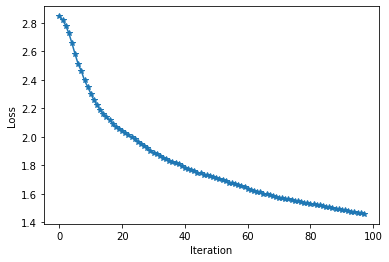

In [ ]:
n_hidden = 128
net = RNN_net(len(name_seq), n_hidden, len(nat_seq))
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)